In [49]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [50]:
import os
os.chdir('C:\\Users\\gmoor\\Documents\\Applied Microeconomics\\Data')

df = pd.read_excel('Washington County Single Family Rentals for five years.xlsx', sheet_name='Washington County Single Family')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3487 entries, 0 to 3486
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   #               3487 non-null   int64         
 1   ML#             3487 non-null   int64         
 2   St              3487 non-null   object        
 3   PT              3487 non-null   object        
 4   Address         3487 non-null   object        
 5   Zip Code        3487 non-null   int64         
 6   Town            3487 non-null   object        
 7   Sub Type        3487 non-null   object        
 8   List Price      3487 non-null   int64         
 9   $               19 non-null     object        
 10  Deposit         3132 non-null   float64       
 11  Date Available  3487 non-null   datetime64[ns]
 12  Beds Total      3487 non-null   int64         
 13  Heated SF /GBA  3487 non-null   int64         
 14  Sold Price      3420 non-null   float64       
 15  Agen

In [52]:
# Prepare the data
df['Date Available'] = pd.to_datetime(df['Date Available'])
df['Price_Per_SF'] = df['List Price'] / df['Heated SF /GBA']
df['Month'] = df['Date Available'].dt.month

df[['Date Available', 'List Price', 'Heated SF /GBA', 'Price_Per_SF', 'Month']].head()

,Date Available,List Price,Heated SF /GBA,Price_Per_SF,Month
0,2019-04-26,1895,2000,0.947500,4
1,2018-07-20,1850,1816,1.018722,7
2,2018-07-20,1675,1900,0.881579,7
3,2020-03-20,1595,1500,1.063333,3
4,2022-05-23,1600,1560,1.025641,5


## 1. Price-Size Relationship Hypothesis
*H0: No relationship between size and price per square foot*

*H1: Larger properties have lower price per square foot*


In [53]:
def test_size_price_relationship():
    # Run regression
    X = df['Heated SF /GBA']
    y = df['Price_Per_SF']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Heated SF /GBA'], df['Price_Per_SF'], alpha=0.5)
    plt.plot(df['Heated SF /GBA'], model.predict(X), color='red', linewidth=2)
    plt.xlabel('Square Footage')
    plt.ylabel('Price per Square Foot')
    plt.title('Property Size vs Price per Square Foot')
    plt.show()
    
    return model.summary()


## 2. Location Premium Hypothesis

*H0: No price difference between cities*

*H1: Prices vary significantly between cities*

In [54]:
def test_location_premium():
    # ANOVA test
    cities = df.groupby('Town')['List Price'].apply(list)
    f_stat, p_value = stats.f_oneway(*cities)
    
    # Box plot visualization
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Town', y='List Price', data=df)
    plt.xticks(rotation=45)
    plt.title('Rental Prices by City')
    plt.show()
    
    return f_stat, p_value

## 3. Market Timing Hypothesis

*H0: No seasonal pattern in prices*

*H1: Prices vary by season*

In [55]:
def test_seasonal_pattern():
    monthly_avg = df.groupby('Month')['List Price'].mean()
    
    # One-way ANOVA
    seasonal_groups = [
        df[df['Month'].isin([12,1,2])]['List Price'],  # Winter
        df[df['Month'].isin([3,4,5])]['List Price'],   # Spring
        df[df['Month'].isin([6,7,8])]['List Price'],   # Summer
        df[df['Month'].isin([9,10,11])]['List Price']  # Fall
    ]
    f_stat, p_value = stats.f_oneway(*seasonal_groups)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    monthly_avg.plot(kind='bar')
    plt.title('Average Rental Price by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Price')
    plt.show()
    
    return f_stat, p_value


## 4. Amenity Valuation Hypothesis

*H0: Bedrooms don't affect price beyond square footage*

*H1: Additional bedrooms command a premium*

In [56]:
def test_bedroom_premium():
    # Multiple regression
    X = df[['Heated SF /GBA', 'Beds Total']]
    y = df['List Price']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    # Visualization
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Beds Total', y='List Price', data=df)
    plt.title('Rental Prices by Number of Bedrooms')
    plt.show()
    
    return model.summary()


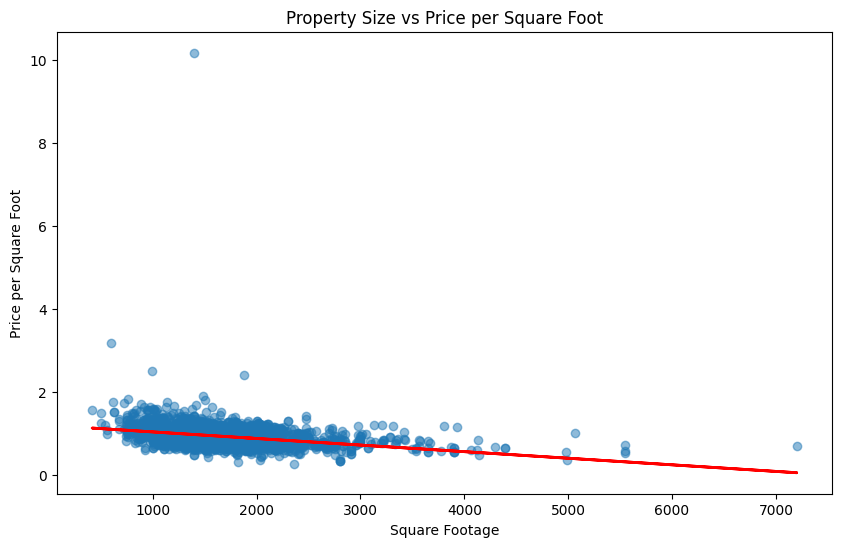

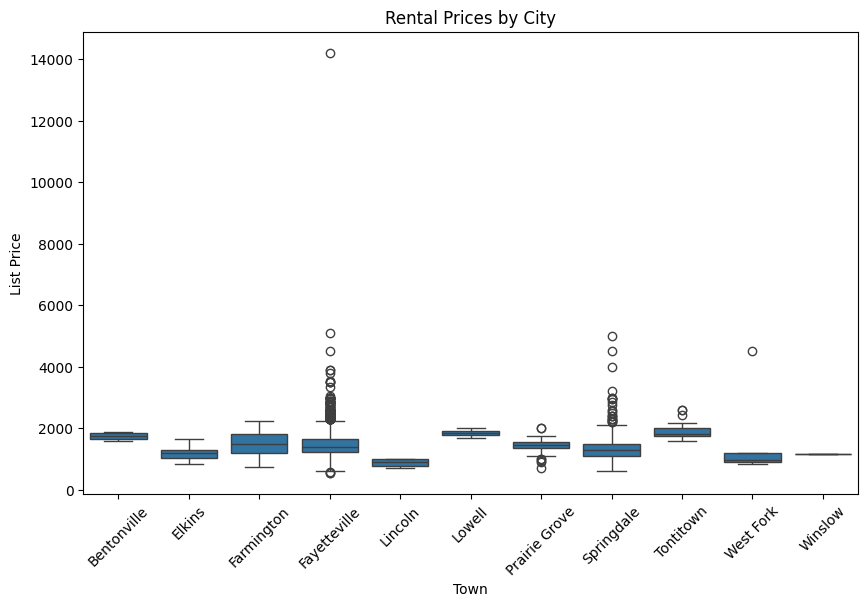

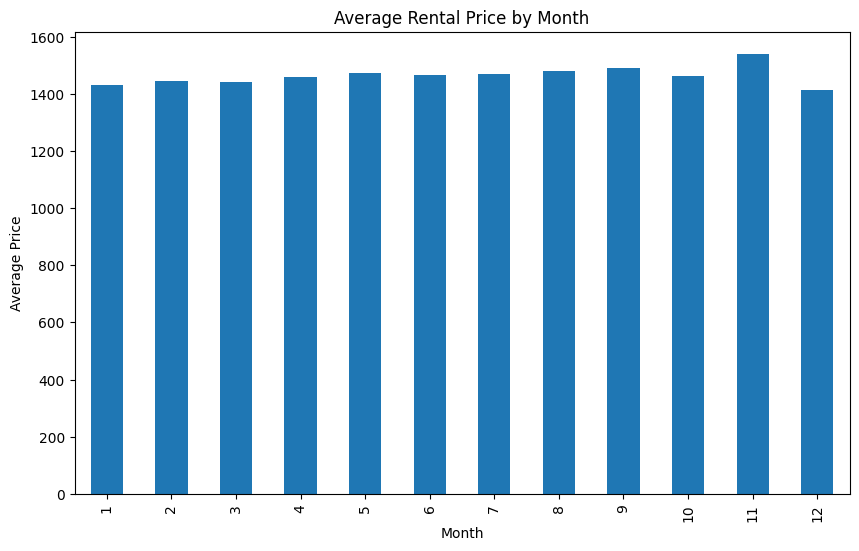

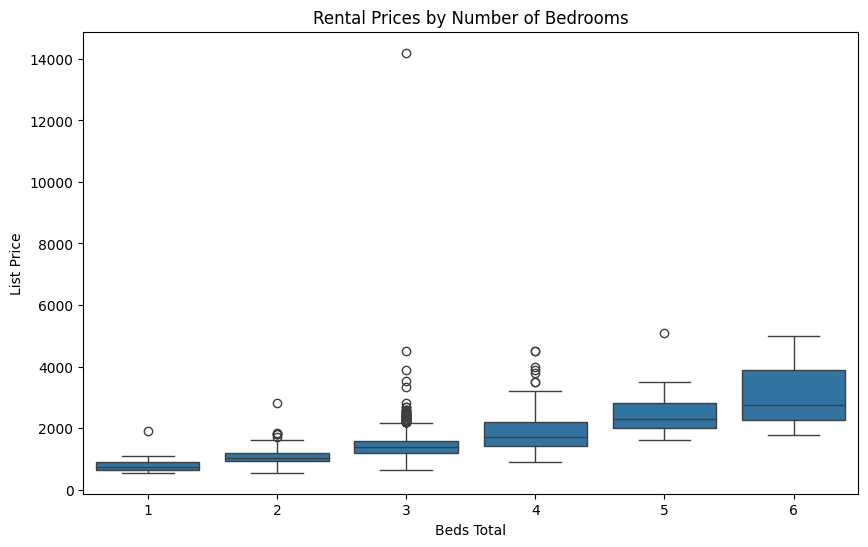

In [57]:
# Run all tests and store results
results = {
    'size_price': test_size_price_relationship(),
    'location': test_location_premium(),
    'seasonal': test_seasonal_pattern(),
    'bedrooms': test_bedroom_premium()
}


In [58]:
# Print results summary
print("\nHypothesis Testing Results:")
print("="*50)
print("\n1. Price-Size Relationship:")
print(results['size_price'])
print("\n2. Location Premium:")
print(f"F-statistic: {results['location'][0]:.2f}")
print(f"p-value: {results['location'][1]:.4f}")
print("\n3. Seasonal Pattern:")
print(f"F-statistic: {results['seasonal'][0]:.2f}")
print(f"p-value: {results['seasonal'][1]:.4f}")
print("\n4. Bedroom Premium:")
print(results['bedrooms'])


Hypothesis Testing Results:

1. Price-Size Relationship:
                            OLS Regression Results                            
Dep. Variable:           Price_Per_SF   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     389.3
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           3.05e-82
Time:                        17:28:26   Log-Likelihood:                 36.245
No. Observations:                3487   AIC:                            -68.49
Df Residuals:                    3485   BIC:                            -56.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------